In [1]:
'''
Title - the title of the GitHub bug, feature, question
Body - the body of the GitHub bug, feature, question
Label - Represents various classes of Labels
        Bug - 0
        Feature - 1
        Question - 2
'''
import numpy as np
import pandas as pd
import json

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
'''
to resolve error:- CancelledError:  [_Derived_]RecvAsync is cancelled.
https://github.com/tensorflow/tensorflow/issues/33721

'''

'\nto resolve error:- CancelledError:  [_Derived_]RecvAsync is cancelled.\nhttps://github.com/tensorflow/tensorflow/issues/33721\n\n'

In [3]:
df_train = pd.read_csv("Cleaned_train.csv", index_col=0)
df_train.head()

,Treated_Text,label
0,c type support generator always reinvoked buil...,0
1,assertj configuration generate late assertj co...,0
2,content editor add tag content editor get remo...,0
3,unity align image functionality work identical...,0
4,okhttp connection leak occasionally notice out...,0


In [4]:
X=df_train['Treated_Text']
y=df_train['label']

In [5]:
Max_Features=8000
Embedding_Dim=256
Max_Length=50

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=Max_Features+1, oov_token='UNK')
tokenizer.fit_on_texts(X)
#print(tokenizer.word_index)
tokenized_text = (tokenizer.texts_to_sequences(X))
X = pad_sequences(tokenized_text, maxlen=Max_Length)

In [7]:
len(tokenizer.word_index)

300288

In [8]:
word_dict = tokenizer.word_index

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [12]:
y_test[0:10]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(196880, 50)
(49220, 50)
(196880, 3)
(49220, 3)


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, Input,Concatenate,Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [15]:
'''
https://stackoverflow.com/questions/63476635/notimplementederror-layer-attention-has-arguments-in-init-and-therefore-m
To solve NotImplementedError: Layer attention has arguments in `__init__` and therefore must override `get_config`

'''

class attention(Layer):
    
    def __init__(self, return_sequences=True,**kwargs):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_sequences': self.return_sequences 
        })
        return config
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [16]:
model = Sequential()
#model.add(Input(shape=(Max_Length,), dtype="int32"))
model.add(Embedding(Max_Features+1, Embedding_Dim, input_length=Max_Length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(attention(return_sequences=True)) # receive 3D and output 3D
model.add(LSTM(32))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 256)           2048256   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           164352    
_________________________________________________________________
attention (attention)        (None, 50, 128)           178       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [17]:
# model = Sequential([
#     Input(shape=(Max_Length,), dtype='int32'),
#     Embedding(Max_Features+1, Embedding_Dim),
#     Bidirectional(LSTM(128)),
#     Dense(128, activation='relu'),
#     Dense(3, activation='softmax')
# ])
# model.summary()

In [18]:
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#tf.config.experimental_run_functions_eagerly(True)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'],
                )

In [19]:
# tf.config.experimental.list_physical_devices('GPU')

In [20]:
# tf.config.experimental.set_memory_growth("GPU:0", enable=True)

In [21]:
Batch_size=128
epochs=30
history = model.fit(x_train, y_train,
          batch_size=Batch_size, epochs=epochs,
          validation_data=(x_test,y_test)
)

Epoch 1/30
1539/1539 [==============================] - 47s 31ms/step - loss: 0.9500 - accuracy: 0.5830 - val_loss: 0.8865 - val_accuracy: 0.6580
Epoch 2/30
1539/1539 [==============================] - 46s 30ms/step - loss: 0.8682 - accuracy: 0.6772 - val_loss: 0.8709 - val_accuracy: 0.6742
Epoch 3/30
1539/1539 [==============================] - 47s 30ms/step - loss: 0.8590 - accuracy: 0.6880 - val_loss: 0.8708 - val_accuracy: 0.6735
Epoch 4/30
1539/1539 [==============================] - 46s 30ms/step - loss: 0.8540 - accuracy: 0.6937 - val_loss: 0.8719 - val_accuracy: 0.6734
Epoch 5/30
1539/1539 [==============================] - 47s 31ms/step - loss: 0.8508 - accuracy: 0.6973 - val_loss: 0.8729 - val_accuracy: 0.6729
Epoch 6/30
1539/1539 [==============================] - 44s 29ms/step - loss: 0.8474 - accuracy: 0.7012 - val_loss: 0.8731 - val_accuracy: 0.6733
Epoch 7/30
1539/1539 [==============================] - 44s 29ms/step - loss: 0.8446 - accuracy: 0.7043 - val_loss: 0.8751 -

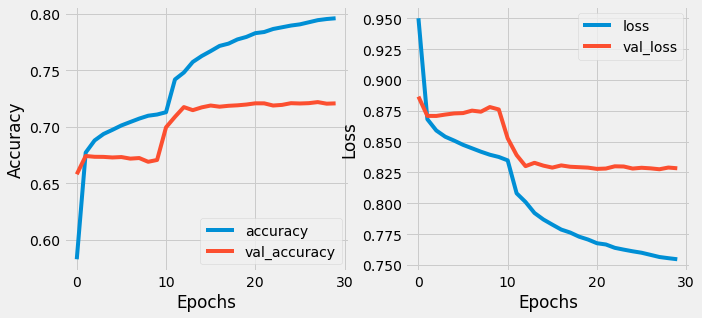

In [22]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=14)
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [23]:
model.save('my_model_att.h5') 

In [24]:
df_test = pd.read_csv('Cleaned_test.csv', index_col=0)
df_test.head()

,Treated_Text
0,config question path specific environment vari...
1,crash indien vol de simulator crasht al hij vo...
2,unable mine rock sarkasmo start today when hit...
3,whitelists process create follow order creatio...
4,add ctx menu idafree idafree associate


In [25]:
x_test = df_test.Treated_Text

In [26]:
tokenized_text = (tokenizer.texts_to_sequences(x_test))
x_test = pad_sequences(tokenized_text, maxlen=Max_Length)

In [27]:
print(x_test.shape)

(30000, 50)


In [28]:
from tensorflow.keras.models import load_model
model = load_model('my_model_att.h5', custom_objects={'attention':attention})

In [29]:
predictions = model.predict(x_test, batch_size=128, verbose=0)

In [30]:
predictions

array([[5.5328439e-07, 6.3174502e-06, 9.9999309e-01],
       [9.9999976e-01, 1.3872910e-10, 1.9903256e-07],
       [9.9999952e-01, 5.6697673e-09, 5.1849162e-07],
       ...,
       [1.0000000e+00, 8.8927433e-12, 4.9187712e-09],
       [1.0000000e+00, 2.2375296e-11, 3.9630876e-08],
       [6.9696205e-07, 1.3108519e-03, 9.9868840e-01]], dtype=float32)

In [31]:
predictions = np.argmax(predictions, axis=1)

In [32]:
#saving in submission format
Submission = pd.DataFrame({'label':predictions})
Submission.head()

,label
0,2
1,0
2,0
3,0
4,1


In [33]:
Submission.to_csv("my_submission_1.csv", index=False)

<AxesSubplot:xlabel='label', ylabel='count'>

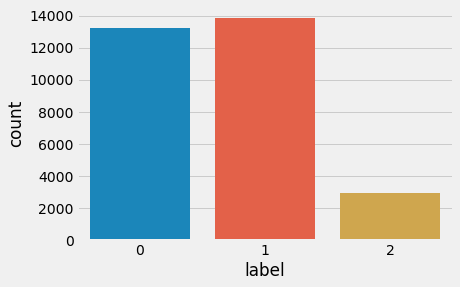

In [34]:
import seaborn as sns
sns.countplot(Submission.label)